# Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
%cd 'CS 4644 Project/transformer_fg'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
/content/drive/.shortcut-targets-by-id/1yXD6mSJrz0PAaR4MeH0QLwszWHOw1Nvg/CS 4644 Project/transformer_fg


In [ ]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import multiprocessing as mp
import sys
import os
import pickle

import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import rdchem


if os.path.abspath('IFG') not in sys.path:
  sys.path.append(os.path.abspath('IFG'))
import ifg
from ifg.chem.molecule import Molecule


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import csv
import random
import regex as re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import pickle
import statistics

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import tqdm
import tqdm.notebook
from tqdm import tqdm
import nltk

In [ ]:
from google.colab import files

In [ ]:
from vocab import FGVocab

In [ ]:
with open('start_data.pkl', 'rb') as file: data = pickle.load(file)

In [ ]:
all_conversations = data['all_conversations ']
eval_conversations = data['eval_conversations']
test_conversations = data['test_conversations']
fg_vocab = data['fg_vocab']
tokenized_fg_reactions = data['all_conversations_fg']
tokenized_fg_reactions_eval = data['eval_conversations_fg']
tokenized_fg_reactions_test = data['test_conversations_fg']

# Model





Then we implement some standard util functions that will be useful in the rest of the code.

#### utils

In [ ]:
# General util functions

def print_list(l, K=None):
	# If K is given then only print first K
	for i, e in enumerate(l):
		if i == K:
			break
		print(e)
	print()

def remove_multiple_spaces(string):
	return re.sub(r'\s+', ' ', string).strip()

def save_in_txt(list_of_strings, save_file):
	with open(save_file, "w") as writer:
		for line in list_of_strings:
			line = line.strip()
			writer.write(f"{line}\n")

def load_from_txt(txt_file):
	with open(txt_file, "r") as reader:
		all_lines = list()
		for line in reader:
			line = line.strip()
			all_lines.append(line)
		return all_lines

Finally we will check if GPU is available and set the device accordingly.

Tip: While debugging use `CPU` and change the runtime type to `GPU` when you are ready to train your models to efficiently use free Colab GPU

In [ ]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print("Using device:", device)

True
Using device: cuda


In [ ]:
print_list(all_conversations, 5)

('N c 1 c c c c c 1 . O = C ( O ) c 1 c c c ( O ) c c 1 ', 'O = C ( N c 1 c c c c c 1 ) c 1 c c c ( O ) c c 1')
('C O c 1 c c c ( C 2 C C c 3 c c ( O C ( = O ) C ( C ) ( C ) C ) c c c 3 C 2 ) c ( N ( C ( = O ) c 2 c c c ( O ) c c 2 ) C ( C ) C ) c 1 . O = C ( C Cl ) N 1 C C 2 C C C ( C C 2 ) C 1 ', 'C O c 1 c c c ( C 2 C C c 3 c c ( O ) c c c 3 C 2 ) c ( N ( C c 2 c c c ( O C C N 3 C C 4 C C C ( C C 4 ) C 3 ) c c 2 ) C ( C ) C ) c 1')
('C [C@] 1 2 C C [C@H] ( c 3 c c c c c 3 ) C [C@@] 1 ( O ) C C [C@@H] 2 C O ', 'C [C@] 1 2 C C [C@H] ( C 3 C C C C C 3 ) C [C@@] 1 ( O ) C C [C@@H] 2 C O')
('C C O C ( = O ) c 1 c ( S C ) c c ( - c 2 c ( C C ) c c c c 2 C C ) n c 1 C ', 'C C c 1 c c c c ( C C ) c 1 - c 1 c c ( S C ) c ( C O ) c ( C ) n 1')
('C S ( = O ) ( = O ) Cl . O C C c 1 c c c ( N 2 C C C C 2 ) c c 1 ', 'C S ( = O ) ( = O ) O C C c 1 c c c ( N 2 C C C C 2 ) c c 1')



## Vocabulary

The words in the sentences need to be converted into integer tokens so that the neural model can operate on them. For this purpose, we will create a vocabulary which will convert the input strings into model recognizable integer tokens.

In [ ]:
fg_vocab.fg_to_idx

In [ ]:
pad_word = "<pad>"
bos_word = "<s>"
eos_word = "</s>"
unk_word = "<unk>"
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3
    
def normalize_sentence(s):
    token_regex = r"(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
    tokens = re.findall(token_regex, s)
    return " ".join(tokens)

class Vocabulary:
    def __init__(self):
        self.word_to_id = {pad_word: pad_id, bos_word: bos_id, eos_word:eos_id, unk_word: unk_id}
        self.word_count = {}
        self.id_to_word = {pad_id: pad_word, bos_id: bos_word, eos_id: eos_word, unk_id: unk_word}
        self.num_words = 4
    
    def get_ids_from_sentence(self, sentence):
        sentence = normalize_sentence(sentence)
        sent_ids = [bos_id] + [self.word_to_id[word] if word in self.word_to_id \
                               else unk_id for word in sentence.split()] + \
                               [eos_id]
        return sent_ids
    
    def tokenized_sentence(self, sentence):
        sent_ids = self.get_ids_from_sentence(sentence)
        return [self.id_to_word[word_id] for word_id in sent_ids]

    def decode_sentence_from_ids(self, sent_ids):
        words = list()
        for i, word_id in enumerate(sent_ids):
            if word_id in [bos_id, eos_id, pad_id]:
                # Skip these words
                continue
            else:
                words.append(self.id_to_word[word_id])
        return ' '.join(words)

    def add_words_from_sentence(self, sentence):
        sentence = normalize_sentence(sentence)
        for word in sentence.split():
            if word not in self.word_to_id:
                # add this word to the vocabulary
                self.word_to_id[word] = self.num_words
                self.id_to_word[self.num_words] = word
                self.word_count[word] = 1
                self.num_words += 1
            else:
                # update the word count
                self.word_count[word] += 1

vocab = Vocabulary()
for src, tgt in all_conversations:
    vocab.add_words_from_sentence(src)
    vocab.add_words_from_sentence(tgt)
print(f"Total words in the vocabulary = {vocab.num_words}")

Total words in the vocabulary = 204


Let's print top 30 vocab words:

In [ ]:
print_list(sorted(vocab.word_count.items(), key=lambda item: item[1], reverse=True), 30)

('c', 7030885)
('C', 5371280)
('(', 3139701)
(')', 3139701)
('O', 2015465)
('1', 1963506)
('2', 1195040)
('=', 1163573)
('N', 854849)
('n', 663473)
('3', 475020)
('F', 389238)
('.', 283714)
('Cl', 248471)
('-', 177040)
('4', 141504)
('S', 140309)
('[C@H]', 113708)
('Br', 101107)
('[C@@H]', 98425)
('[nH]', 70359)
('#', 69971)
('[O-]', 66611)
('s', 58175)
('[N+]', 54017)
('o', 41129)
('/', 33576)
('5', 29496)
('[Si]', 22876)
('I', 20778)



Print a couple of sentences to verify that the vocabulary is working as intended.

In [ ]:
for src, tgt in all_conversations[:3]:
    sentence = tgt
    word_tokens = vocab.tokenized_sentence(sentence)
    # Automatically adds bos_id and eos_id before and after sentence ids respectively
    word_ids = vocab.get_ids_from_sentence(sentence)
    print(sentence)
    print(word_tokens)
    print(word_ids)
    print(vocab.decode_sentence_from_ids(word_ids))
    print()

word = "C"
word_id = vocab.word_to_id[word]
print(f"Word = {word}")
print(f"Word ID = {word_id}")
print(f"Word decoded from ID = {vocab.decode_sentence_from_ids([word_id])}")

O = C ( N c 1 c c c c c 1 ) c 1 c c c ( O ) c c 1
['<s>', 'O', '=', 'C', '(', 'N', 'c', '1', 'c', 'c', 'c', 'c', 'c', '1', ')', 'c', '1', 'c', 'c', 'c', '(', 'O', ')', 'c', 'c', '1', '</s>']
[1, 8, 9, 10, 11, 4, 5, 6, 5, 5, 5, 5, 5, 6, 12, 5, 6, 5, 5, 5, 11, 8, 12, 5, 5, 6, 2]
O = C ( N c 1 c c c c c 1 ) c 1 c c c ( O ) c c 1

C O c 1 c c c ( C 2 C C c 3 c c ( O ) c c c 3 C 2 ) c ( N ( C c 2 c c c ( O C C N 3 C C 4 C C C ( C C 4 ) C 3 ) c c 2 ) C ( C ) C ) c 1
['<s>', 'C', 'O', 'c', '1', 'c', 'c', 'c', '(', 'C', '2', 'C', 'C', 'c', '3', 'c', 'c', '(', 'O', ')', 'c', 'c', 'c', '3', 'C', '2', ')', 'c', '(', 'N', '(', 'C', 'c', '2', 'c', 'c', 'c', '(', 'O', 'C', 'C', 'N', '3', 'C', 'C', '4', 'C', 'C', 'C', '(', 'C', 'C', '4', ')', 'C', '3', ')', 'c', 'c', '2', ')', 'C', '(', 'C', ')', 'C', ')', 'c', '1', '</s>']
[1, 10, 8, 5, 6, 5, 5, 5, 11, 10, 13, 10, 10, 5, 14, 5, 5, 11, 8, 12, 5, 5, 5, 14, 10, 13, 12, 5, 11, 4, 11, 10, 5, 13, 5, 5, 5, 11, 8, 10, 10, 4, 14, 10, 10, 16, 10, 10, 10, 11, 

## Dataset Prepration (5 points)

We will use built-in dataset utilities, `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`, to get batched data readily useful for training.

In [ ]:
class ReactionDataset(Dataset):

    def __init__(self, reactions, tokenized_fg_reactions, vocab, fg_vocab, device):
        self.vocab = vocab
        self.fg_vocab = fg_vocab
        self.device = device
        self.reactions = reactions
        self.tokenized_reactions = [(self.vocab.get_ids_from_sentence(src), self.vocab.get_ids_from_sentence(tgt)) for src, tgt in self.reactions]
        self.tokenized_fg_reactions = tokenized_fg_reactions
        
    def __len__(self): return len(self.reactions)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return { "rxn":self.tokenized_reactions[idx], "fgs":self.tokenized_fg_reactions[idx]}



In [ ]:
def collate_fn(data):
    # Sort conv_ids based on decreasing order of the src_lengths.
    src_ids = [torch.LongTensor(e["rxn"][0]) for e in data]
    tgt_ids = [torch.LongTensor(e["rxn"][1]) for e in data]
    src_fgs = [torch.LongTensor(e["fgs"][0]) for e in data]
    tgt_fgs = [torch.LongTensor(e["fgs"][1]) for e in data]
    
    data = list(zip(src_ids, tgt_ids, src_fgs, tgt_fgs))
    data.sort(key=lambda x: len(x[0]), reverse=True)
    src_ids, tgt_ids, src_fgs, tgt_fgs = zip(*data)

    src_seqs = pad_sequence(src_ids, False, pad_id)     # (Pad, B)
    tgt_seqs = pad_sequence(tgt_ids, False, pad_id)     # (Pad, B)

    src_fgs = pad_sequence(src_fgs, True, 0)           #(B, FGV)
    tgt_fgs = pad_sequence(tgt_fgs, True, 0)           #(B, FGV)
    
    return {"fg_tensors":(src_fgs.to(device), tgt_fgs.to(device)), "rxn_tensors":(src_seqs.to(device), tgt_seqs.to(device))}

In [ ]:

train_dataset = ReactionDataset(all_conversations, tokenized_fg_reactions, vocab, fg_vocab, device)
eval_dataset = ReactionDataset(eval_conversations,tokenized_fg_reactions_eval, vocab,fg_vocab, device)
test_dataset = ReactionDataset(test_conversations, tokenized_fg_reactions_eval, vocab,fg_vocab, device)

batch_size = 128

train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, 
                               shuffle=True, collate_fn=collate_fn)
val_data_loader = DataLoader(dataset=eval_dataset, batch_size=batch_size, 
                               shuffle=True, collate_fn=collate_fn)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, 
                               shuffle=True, collate_fn=collate_fn)
                              

In [ ]:
# Test one batch of training data
first_batch = next(iter(train_data_loader))

reactant_batch, product_batch = first_batch['rxn_tensors']      
reactant_batch_fg, product_batch_fg = first_batch['fg_tensors']

print(len(reactant_batch),len(reactant_batch[0]))
print(len(product_batch),len(product_batch[0]))
print(len(reactant_batch_fg),len(reactant_batch_fg[0]))
print(len(product_batch_fg),len(product_batch_fg[0]))



130 128
99 128
128 113
128 113


## Baseline Seq2Seq model (25 points)

### Transformer

In [ ]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


class ChemSeq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 vocab_size: int,
                 fg_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1,
                 ):
        super(ChemSeq2SeqTransformer, self).__init__()

        self.transformer = nn.Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator_smiles = nn.Linear(emb_size, vocab_size)
        self.generator_fgv = nn.Linear(emb_size, fg_vocab_size)
   
        self.src_tok_emb = TokenEmbedding(vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        
        self.fc_fg = nn.Linear(fg_vocab_size, emb_size)

    def forward(self, src, src_fg, trg, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        # src: (SLEN, B)
        # src_fg: (B, FGV)
        # trg: (TLEN, B)    

        src_tok_emb = self.src_tok_emb(src) #(S, B, E)
        trg_tok_emb = self.tgt_tok_emb(trg) #(T, B, E)

        src_emb = self.positional_encoding(src_tok_emb)  # (S, B, E)
        trg_emb = self.positional_encoding(trg_tok_emb)  # (T, B, E)
        
        encoded_src = self.transformer.encoder(src_emb, src_mask)  # (S, B, E)

        # Modifiable : How the encoded seq and
        
        encoded_fgv = self.fc_fg(src_fg) # (B, E)
        encoded_fgv = encoded_fgv.unsqueeze(1).repeat(1, encoded_src.size(0), 1)  # (B, S, E)
        combined_src = encoded_src + encoded_fgv.transpose(1, 0)                  # (S, B, E)

        memory = self.transformer.decoder(
            trg_emb, 
            combined_src, 
            tgt_mask,
            None, 
            tgt_padding_mask, 
            memory_key_padding_mask
            )  # (T, B, E)
        
        product_smiles = self.generator_smiles(memory)  # (T, B, TVocab)

        product_fgv = self.generator_fgv(memory)      # (T, B, FGV)
        product_fgv = torch.sum(product_fgv, axis = 0)  #  B, FGV)

        return product_smiles, product_fgv

### Training and hyperparams 

#### utils

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len, tgt_seq_len = src.shape[0], tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = generate_square_subsequent_mask(src_seq_len)

    src_padding_mask = (src == pad_id).transpose(0, 1)
    tgt_padding_mask = (tgt == pad_id).transpose(0, 1)

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

#### hyper params

In [ ]:
torch.manual_seed(0)

# MODEL HYPER PARAMETERS
NUM_EPOCHS = 30
SRC_VOCAB_SIZE = vocab.num_words
FGVOCAB_SIZE = fg_vocab.vocab_size
EMB_SIZE = 200
NHEAD = 5
FFN_HID_DIM = 1024
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DROPOUT = 0.1

transformer = ChemSeq2SeqTransformer(
    NUM_ENCODER_LAYERS,
    NUM_DECODER_LAYERS,
    EMB_SIZE,
    NHEAD,
    SRC_VOCAB_SIZE, 
    FGVOCAB_SIZE, 
    FFN_HID_DIM, 
    DROPOUT
    )

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)


transformer = transformer.to(device)

# pipeline 
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

criterion_smiles = nn.CrossEntropyLoss(ignore_index=pad_id)
criterion_fgv = nn.CrossEntropyLoss()

w_fg_loss = 0.08

### training

In [ ]:
import tqdm.notebook

In [ ]:
#todo : 1) check output shape of the product strings from the transformer. 2) find a way to get text outputs ( see the utils file ). 3) get the eval/test reaction set. 4) set up accuracy metric 

In [ ]:
# clip = 50.0
train_losses = []
val_losses = []
for epoch in tqdm.notebook.trange(NUM_EPOCHS, desc="training", unit="epoch"):
    with tqdm.notebook.tqdm(
            train_data_loader,
            desc="epoch {}".format(epoch + 1),
            unit="batch",
            total=len(train_data_loader)) as batch_iterator:
        transformer.train()
        epoch_train_loss = 0.0
        for i, batch in enumerate(batch_iterator, start=1):

            #forward pass
            optimizer.zero_grad()
            src, tgt = batch['rxn_tensors']
            src_fg, tgt_fg = batch['fg_tensors']
            src_fg, tgt_fg = src_fg.float(), tgt_fg.float()
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt)

            logits, output_fgv = transformer(
                src, 
                src_fg,
                tgt, 
                src_mask, 
                tgt_mask, 
                src_padding_mask, 
                tgt_padding_mask, 
                src_padding_mask
                )

            # Calculate loss
            
            # tgt_out = tgt[1:, :].reshape(-1)
            # logits = logits.reshape(-1, logits.shape[-1])

            loss_smiles = criterion_smiles(logits[1:].reshape(-1, logits.shape[2]), tgt[1:].reshape(-1))
            loss_fgv = criterion_fgv(output_fgv, tgt_fg)
            loss = loss_smiles +(w_fg_loss * loss_fgv)
            # Backpropagation
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss_smiles.item()

            # Gradient clipping before taking the step
            # _ = nn.utils.clip_grad_norm_(model.parameters(), clip)
            

            batch_iterator.set_postfix(mean_loss=epoch_train_loss / i, current_loss= loss_smiles.item(), fg_loss =loss_fgv.item() )
        val_loss = evaluate(transformer, val_data_loader)
        scheduler.step(val_loss)

        train_losses.append(epoch_train_loss)
        val_losses.append(val_loss)

torch.save(transformer.state_dict(), 'model.pt')

In [ ]:
def evaluate(model, val_dataloader):
    model.eval()
    losses = 0

    with torch.no_grad():
        for batch in val_dataloader:
            src, tgt = batch['rxn_tensors']
            src_fg, tgt_fg = batch['fg_tensors']
            src_fg, tgt_fg = src_fg.float(), tgt_fg.float()
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt)

            output_smiles, output_fgv = transformer(
                src, 
                src_fg,
                tgt, 
                src_mask, 
                tgt_mask, 
                src_padding_mask, 
                tgt_padding_mask, 
                src_padding_mask
                )

            # Calculate loss
            output_smiles = output_smiles.view(-1, output_smiles.shape[-1])
            tgt = tgt.view(-1)
            loss_smiles = criterion_smiles(output_smiles, tgt)
            loss_fgv = criterion_fgv(output_fgv, tgt_fg)
            loss = loss_smiles +(w_fg_loss * loss_fgv)
            losses+= loss_smiles.item()

    print("Val loss: ", losses / len(list(val_dataloader)))
    return losses / len(list(val_dataloader))

In [ ]:
files.download('baseline_model.pt')

We can now train the baseline model.

A correct implementation should get a average train loss of < 3.00  
The code will automatically save and download the model at the end of training.

### Decoding

data_help.py  model.pt      start_data.pkl       vocab.py
IFG/          __pycache__/  TransformerFG.ipynb


In [ ]:
import data_help

In [ ]:
from data_help import rxn_fgs, idx_tokenize_reactions

In [ ]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, src_fg, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)
    src_tok_emb = model.src_tok_emb(src) #(S, B, E)
    src_emb = model.positional_encoding(src_tok_emb)  # (S, B, E)
    encoded_src = model.transformer.encoder(src_emb, src_mask)  # (S, B, E)
    
    encoded_fgv = model.fc_fg(src_fg).unsqueeze(1).repeat(1, encoded_src.size(0), 1)  # (B, S, E)
    
    memory = encoded_src + encoded_fgv.transpose(1, 0)  # (S, B, E)
    
    product_fgv = model.generator_fgv(memory)      # (T, B, FGV)
    product_fgv = torch.sum(product_fgv, axis = 0)  #  B, FGV)

    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    sentence = ""

    with torch.no_grad():
      for i in range(max_len-1):
          memory = memory.to(device)
          tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                      .type(torch.bool)).to(device)

          y_embs = model.positional_encoding(model.tgt_tok_emb(ys))
          memory = model.transformer.decoder(y_embs, memory, tgt_mask)
          prob = model.generator_smiles(memory)
          
          next_word = torch.argmax(prob, dim=-1)
          
          next_word = next_word[-1].item()
          print(next_word)
          
          sentence += f"{vocab.decode_sentence_from_ids([next_word])} "

          ys = torch.cat([ys,
                          torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
          if next_word == eos_id:break
    return ys, sentence

# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src: str,  src_fg):
    model.eval()
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

    tgt_tokens, sentence = greedy_decode(
        model,  src, src_mask,src_fg, max_len=num_tokens + 5, start_symbol=bos_id)
    
    return sentence

In [ ]:
def test(src):
  src_fg, _ = fg_vocab.vectorize_reaction(rxn_fgs((src, "")))
  src, src_fg = torch.tensor(vocab.get_ids_from_sentence(src)).to(device), torch.tensor(src_fg).to(device).float()
  src, src_fg = src.unsqueeze(1), src_fg.unsqueeze(0)
  return translate(transformer, src, src_fg)

test(all_conversations[0][0])

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


'c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c '

In [ ]:
baseline_chat = chat_with_model(baseline_model)

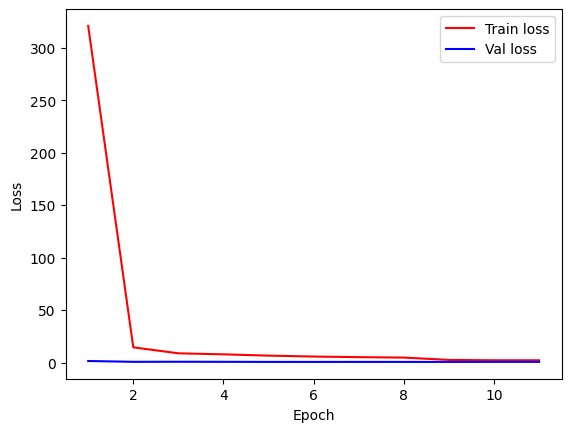

In [ ]:
import matplotlib.pyplot as plt

plt.plot( np.arange(1,12),train_losses[1:], 'r',label ="Train loss" ) # plotting t, a separately 
plt.plot( np.arange(1,12), val_losses[:-1], 'b', label= "Val loss") # plotting t, a separately 
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
